In [91]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy import io as sio

from utils import GenerateHaarFeatureMasks, ExtractHaarFeatures
from classifier import WeakClassifier, WeakClassifierError, ErrorRate

plt.rcParams['figure.facecolor']='white'

In [118]:
# Number of randomized Haar-features
np.random.seed(456)
# Number of randomized Haar-features
nbrHaarFeatures = 60
# Number of training images, will be evenly split between faces and
# non-faces. (Should be even.)
nbrTrainImages = 2000
# Number of weak classifiers
nbrWeakClassifiers = 50

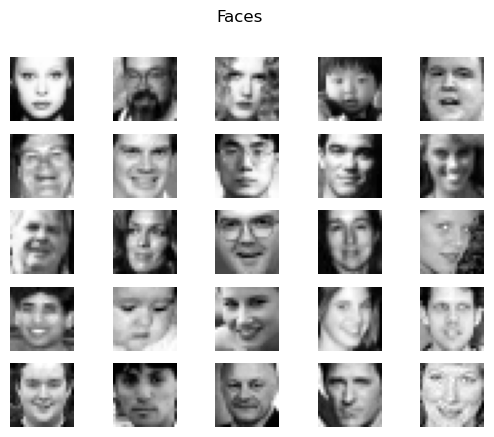

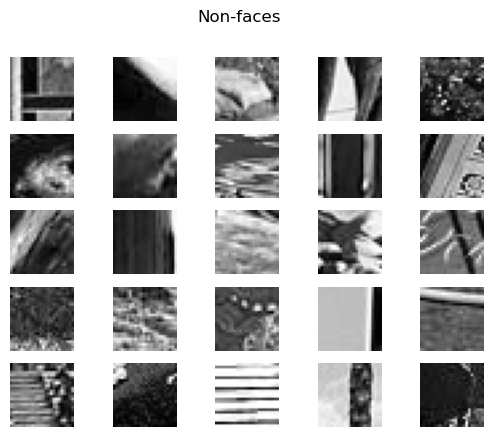

In [119]:
# Load face and non-face data and plot a few examples
faces = sio.loadmat('faces.mat')['faces']
nonfaces = sio.loadmat('nonfaces.mat')['nonfaces']
# 4916 7872
faces = faces.astype('double')[:,:,np.random.permutation(faces.shape[-1])]
nonfaces = nonfaces.astype('double')[:,:,np.random.permutation(nonfaces.shape[-1])]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(faces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(nonfaces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()

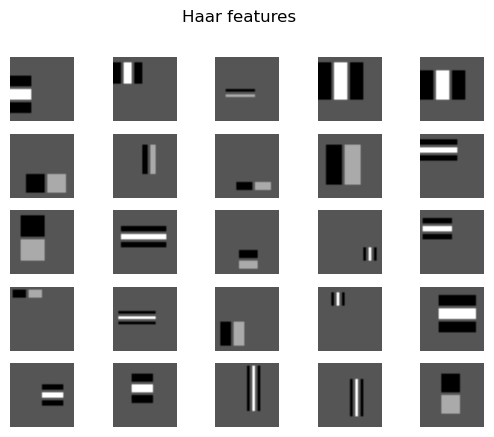

In [147]:
# Generate Haar feature masks
haarFeatureMasks = GenerateHaarFeatureMasks(nbrHaarFeatures)
plt.figure()
for k in range(25):
    plt.subplot(5,5,k+1)
    plt.imshow(haarFeatureMasks[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()

In [149]:
# Create image sets (do not modify!)

# Create a training data set with examples from both classes.
# Non-faces = class label y=-1, faces = class label y=1
trainImages = np.concatenate((faces[:,:,:nbrTrainImages//2], nonfaces[:,:,:nbrTrainImages//2]), axis=2)
xTrain = ExtractHaarFeatures(trainImages,haarFeatureMasks)
yTrain = np.concatenate((np.ones(nbrTrainImages//2), -np.ones(nbrTrainImages//2)))

# Create a test data set, using the rest of the faces and non-faces.
testImages  = np.concatenate((faces[:,:,nbrTrainImages//2:], nonfaces[:,:,nbrTrainImages//2:]), axis=2)
xTest = ExtractHaarFeatures(testImages,haarFeatureMasks)
yTest = np.concatenate((np.ones(faces.shape[2]-nbrTrainImages//2), -np.ones(nonfaces.shape[2]-nbrTrainImages//2)))

# Variable for the number of test-data.
nbrTestImages = yTest.shape

In [164]:
print(testImages.shape)

(24, 24, 10788)


In [151]:
# Implement the AdaBoost training here
# Use your implementation of WeakClassifier and WeakClassifierError in classifier.py
classifier_list = []
weight = np.ones(nbrTrainImages) / nbrTrainImages

for i in range(nbrWeakClassifiers):
    best_fea = 0
    best_thre = None
    best_error = np.Inf
    best_cla = None
    best_P = 1
    for selected_feature_index in range(nbrHaarFeatures):
        selected_feature = xTrain[selected_feature_index, :]
        # this loop is to find best threshold
        for threshold in sorted(selected_feature):
            P = 1
            wcl = WeakClassifier(threshold, P, selected_feature)
            error = WeakClassifierError(wcl, weight, yTrain)
            if error >= 0.5:
                P = -1
                wcl = WeakClassifier(threshold, P, selected_feature)
                error = WeakClassifierError(wcl, weight, yTrain)
            # whether this threshold is the best
            if error < best_error:
                best_error = error
                best_thre = threshold
                best_cla = wcl
                best_fea = selected_feature_index
                best_P = P
    # update weights
    C = np.ones_like(yTrain)
    C[best_cla != yTrain] = -2
    C[best_cla == yTrain] = 2
    C /= 2
    C = np.int8(C)
    alpha_t = 1 / 2 * np.log((1 - best_error) / best_error )
    new_weight = weight * np.exp(-alpha_t * C)
    new_weight[new_weight > 1/(nbrTrainImages/10)] = 1/(nbrTrainImages/10)
    new_weight = new_weight / sum(new_weight)
    weight = new_weight
    classifier_list.append((best_fea, best_thre, best_P, alpha_t))
    # reset for next iteration
    if i % 5 == 0:
        print('{} finished among {} in total'.format(i, nbrWeakClassifiers))
print('{} finished among {} in total'.format(nbrWeakClassifiers, nbrWeakClassifiers))



0 finished among 50 in total
5 finished among 50 in total
10 finished among 50 in total
15 finished among 50 in total
20 finished among 50 in total
25 finished among 50 in total
30 finished among 50 in total
35 finished among 50 in total
40 finished among 50 in total
45 finished among 50 in total
50 finished among 50 in total


In [156]:
# Evaluate your strong classifier here
# Evaluate on both the training data and test data, but only the test accuracy
# can be used as a performance metric since the training accuracy is biased.
train_res = 0
train_res_list = []
for weak in range(len(classifier_list)):
    cla = classifier_list[weak]
    selected = xTrain[cla[0], :]
    train_res += WeakClassifier(cla[1], cla[2], selected) * cla[3]
    train_temp = np.sign(train_res)
    acctr_temp = sum(train_temp == yTrain) / len(yTrain)
    train_res_list.append(acctr_temp)

train_res = np.sign(train_res)
acctr = sum(train_res == yTrain) / len(yTrain)
print('Train accurate rate is {}'.format(acctr))

test_res = 0
test_res_list = []
for weak in range(len(classifier_list)):
    cla = classifier_list[weak]
    selected = xTest[cla[0], :]
    test_res += WeakClassifier(cla[1], cla[2], selected) * cla[3]
    test_temp = np.sign(test_res)
    acctr_temp = sum(test_temp == yTest) / len(yTest)
    test_res_list.append(acctr_temp)
    
test_res = np.sign(test_res)
accte = sum(test_res == yTest) / len(yTest)
print('Test accurate rate is {}'.format(accte))

Train accurate rate is 0.965
Test accurate rate is 0.9346496106785317


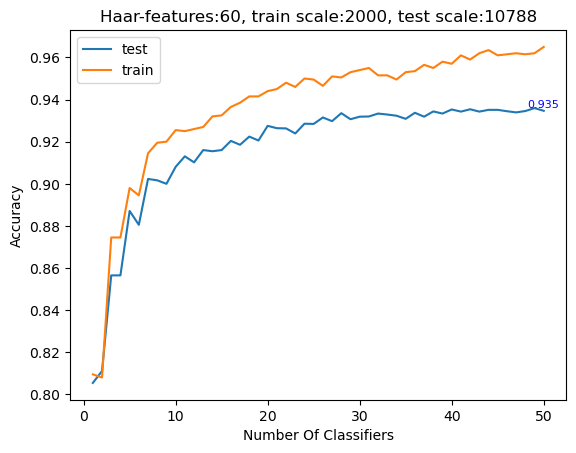

In [167]:
# Plot the error of the strong classifier as a function of the number of weak classifiers.
# Note: you can find this error without re-training with a different number of weak classifiers.

fig, ax = plt.subplots() # 创建图实例
x = [x for x in range(1,nbrWeakClassifiers+1)] # 创建x的取值范围
ytest = test_res_list
ax.plot(x, ytest, label='test') # 作y1 = x 图，并标记此线名为linear
ytrain = train_res_list
ax.plot(x, ytrain, label='train') #作y2 = x^2 图，并标记此线名为quadratic
ax.set_xlabel('Number Of Classifiers') #设置x轴名称 x label
ax.set_ylabel('Accuracy') #设置y轴名称 y label
ax.set_title('Haar-features:60, train scale:2000, test scale:10788') #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.text(nbrWeakClassifiers, np.round(ytest[-1],3), np.round(ytest[-1],3), ha='center', va='bottom', fontsize=8, color='blue' )
plt.show() #图形可视化


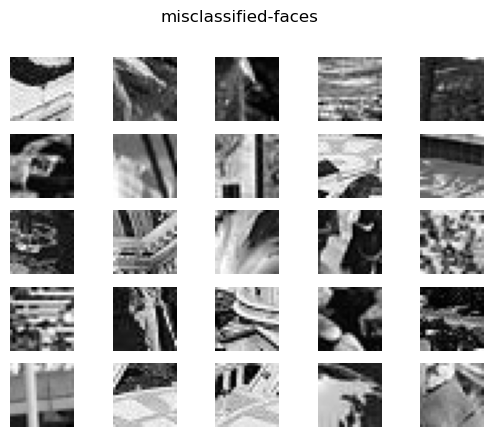

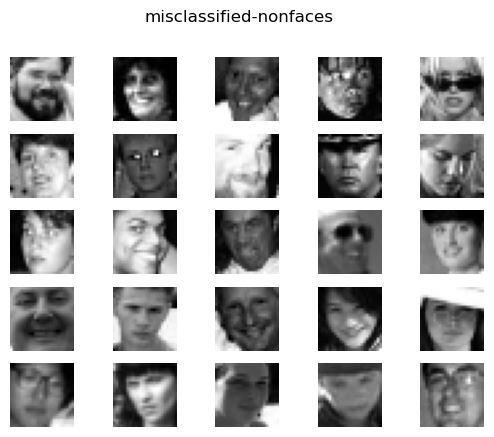

In [169]:
# Plot some of the misclassified faces and non-faces
# Use the subplot command to make nice figures with multiple images.
misclassified = [x for x in range(len((test_res == yTest))) if (test_res == yTest)[x] == False]
misclassified_faces = [x for x in misclassified if test_res[x]==1][27:52]
misclassified_nonfaces = [x for x in misclassified if test_res[x]==-1][27:52]

plt.figure()
for i in range(len(misclassified_faces)):
    plt.subplot(5,5,i+1)
    plt.imshow(testImages[:,:,misclassified_faces[i]], cmap='gray')
    plt.axis('off')
plt.suptitle('misclassified-faces')

plt.figure()
for i in range(len(misclassified_nonfaces)):
    plt.subplot(5,5,i+1)
    plt.imshow(testImages[:,:,misclassified_nonfaces[i]], cmap='gray')
    plt.axis('off')
plt.suptitle('misclassified-nonfaces')
plt.show()



32


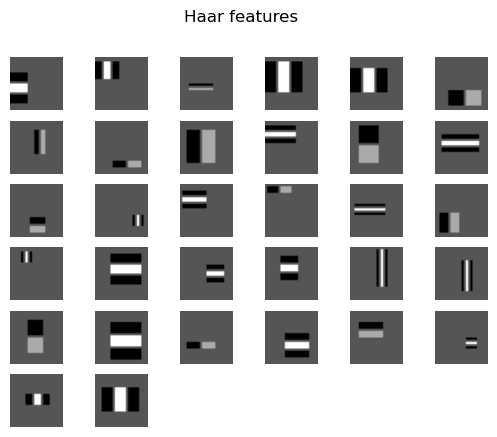

In [155]:
# Plot your choosen Haar-features
# Use the subplot command to make nice figures with multiple images.
haar_index_list = set([x[0] for x in classifier_list])
print(len(haar_index_list))
plt.figure()
for k in range(len(haar_index_list)):
    plt.subplot(6,np.int8(np.floor(len(haar_index_list)/6))+1,k+1)
    plt.imshow(haarFeatureMasks[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()

